# Traffic sign detection and classification (with deep learning)

In [ ]:
import cv2 as cv
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchinfo import summary
import torchmetrics
from sklearn.metrics import accuracy_score
import xml.etree.ElementTree as ET

In [ ]:
def displayImage(image, title=""):
    if (len(image.shape) == 3):
        cmap = None

    else:
        cmap = "gray"
        
    plt.rcParams['figure.figsize'] = [10, 10]
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

## Data preparation

In [ ]:
# Get train and validation datasets
images_directory = "../dataset/images"
annotations_directory = "../dataset/annotations"

with open("train.txt") as train:
    train_images_filenames = sorted(train.read().splitlines())

with open("test.txt") as test:
    val_images_filenames = sorted(test.read().splitlines())

# Filter out images that can not be loaded properly
train_images_filenames = [i for i in train_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]
val_images_filenames = [i for i in val_images_filenames if cv.imread(os.path.join(images_directory, i + ".png")) is not None]

random.seed(42)
random.shuffle(train_images_filenames)
random.shuffle(val_images_filenames)

print(len(train_images_filenames), len(val_images_filenames))

## Dataset class

In [ ]:
classes = {
    "trafficlight": 0,
    "stop": 1,
    "speedlimit": 2,
    "crosswalk": 3,
}

class TrafficSignDataset(Dataset):
    def __init__(self, annotations_directory, images_filenames, images_directory, transform=None):
        self.annotations_directory = annotations_directory
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv.imread(os.path.join(
            self.images_directory, image_filename + ".png"))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        if self.transform is not None:
            transformed = self.transform(image=image)
            image = transformed["image"]

        return image.float(), self._get_max_area_class_from_annotion(image_filename)

    def _get_max_area_class_from_annotion(self, filename):
        with open(os.path.join(self.annotations_directory, filename + ".xml")) as xml:
            tree = ET.parse(xml)
            root = tree.getroot()

            max_area_class = "trafficlight"
            max_area = -1

            objects = root.findall("object")
            for object in objects:
                xmin = int(object.find("bndbox/xmin").text)
                ymin = int(object.find("bndbox/ymin").text)
                xmax = int(object.find("bndbox/xmax").text)
                ymax = int(object.find("bndbox/ymax").text)

                area = (xmax - xmin) * (ymax - ymin)

                if area > max_area:
                    max_area = area
                    max_area_class = object.find("name").text

        return classes[max_area_class]

## Load data

In [ ]:
batch_size = 10
num_workers = 0 # How many processes are used to load the data

train_transform = A.Compose(
    [
        A.Resize(256, 256),
        ToTensorV2(),
    ]
)
train_dataset = TrafficSignDataset(annotations_directory, train_images_filenames, images_directory, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)


val_transform = A.Compose(
    [A.Resize(256, 256), ToTensorV2()]
)
val_dataset = TrafficSignDataset(annotations_directory, val_images_filenames, images_directory, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, drop_last=False)

index = 10
print(train_images_filenames[index])
# displayImage(train_dataset[index][0])
print(train_dataset[index][1])

## Train the model

In [ ]:
num_classes = 4

# Get CPU or GPU device for training
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
        assert optimizer is not None, "When training, please provide an optimizer."

    num_batches = len(dataloader)

    if is_train:
        model.train()  # put model in train mode
        
    else:
        model.eval()

    total_loss = 0.0
    preds = []
    labels = []

    with torch.set_grad_enabled(is_train):
        for batch, (X, y) in enumerate(tqdm(dataloader)):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            if is_train:
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Save training metrics
            # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached
            total_loss += loss.item()

            probs = F.softmax(pred, dim=1)
            final_pred = torch.argmax(probs, dim=1)
            preds.extend(final_pred.cpu().numpy())
            labels.extend(y.cpu().numpy())

    return total_loss / num_batches, accuracy_score(labels, preds)

In [ ]:
def train(model, model_name, num_epochs, train_dataloader, validation_dataloader, loss_fn, optimizer):
    train_history = {'loss': [], 'accuracy': []}
    val_history = {'loss': [], 'accuracy': []}
    best_val_loss = np.inf
    print("Start training...")

    for t in range(num_epochs):
        print(f"\nEpoch {t+1}")

        train_loss, train_acc = epoch_iter(train_dataloader, model, loss_fn, optimizer)

        print(f"Train loss: {train_loss:.3f} \t Train acc: {train_acc:.3f}")

        val_loss, val_acc = epoch_iter(validation_dataloader, model, loss_fn, is_train=False)
        print(f"Val loss: {val_loss:.3f} \t Val acc: {val_acc:.3f}")

        # Save model when validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_dict = {'model': model.state_dict(
            ), 'optimizer': optimizer.state_dict(), 'epoch': t}
            torch.save(save_dict, model_name + '_best_model.pth')

        # Save latest model
        save_dict = {
            'model': model.state_dict(), 
            'optimizer': optimizer.state_dict(), 
            'epoch': t
        }
        
        torch.save(save_dict, model_name + '_latest_model.pth')

        # save training history for plotting purposes
        train_history["loss"].append(train_loss)
        train_history["accuracy"].append(train_acc)

        val_history["loss"].append(val_loss)
        val_history["accuracy"].append(val_acc)

    print("Finished")

    return train_history, val_history

In [ ]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Classification Accuracy')
    plt.plot(train_history['accuracy'], label='train')
    plt.plot(val_history['accuracy'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

### ResNet-50 pretrained

In [ ]:
resnet = models.resnet50(pretrained=True)

# change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
resnet.fc = nn.Linear(in_features=2048, out_features=num_classes, bias=True)

resnet.to(device)
print(resnet)

In [ ]:
num_epochs = 50
model_name = 'resnet50'

loss_fn = nn.CrossEntropyLoss()  # already includes the Softmax activation
optimizer_resnet = torch.optim.SGD(resnet.parameters(), lr=1e-3)

resnet_train_history, resnet_val_history = train(resnet, model_name, num_epochs, train_dataloader, val_dataloader, loss_fn, optimizer_resnet)

plotTrainingHistory(resnet_train_history, resnet_val_history)

### VGG-16

In [ ]:
# Load model from torchvision (with pretrained=True)
vgg = models.vgg16(pretrained=True)

# Change the number of neurons in the last layer to the number of classes of the problem at hand (CIFAR10 dataset)
vgg.classifier[6] = nn.Linear(4096, num_classes)

vgg.to(device)

Start training...

Epoch 1


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:12<00:00,  2.17s/it]


Train loss: 0.641 	 Train acc: 0.777


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.63it/s]


Val loss: 0.530 	 Val acc: 0.833

Epoch 2


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:11<00:00,  2.16s/it]


Train loss: 0.449 	 Train acc: 0.849


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.63it/s]


Val loss: 0.376 	 Val acc: 0.902

Epoch 3


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:12<00:00,  2.17s/it]


Train loss: 0.321 	 Train acc: 0.898


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.59it/s]


Val loss: 0.301 	 Val acc: 0.920

Epoch 4


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:12<00:00,  2.17s/it]


Train loss: 0.225 	 Train acc: 0.939


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:17<00:00,  1.58it/s]


Val loss: 0.264 	 Val acc: 0.928

Epoch 5


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:11<00:00,  2.16s/it]


Train loss: 0.170 	 Train acc: 0.946


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.62it/s]


Val loss: 0.252 	 Val acc: 0.924

Epoch 6


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:11<00:00,  2.15s/it]


Train loss: 0.151 	 Train acc: 0.952


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.63it/s]


Val loss: 0.223 	 Val acc: 0.936

Epoch 7


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:12<00:00,  2.16s/it]


Train loss: 0.099 	 Train acc: 0.969


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:17<00:00,  1.59it/s]


Val loss: 0.229 	 Val acc: 0.932

Epoch 8


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:12<00:00,  2.16s/it]


Train loss: 0.086 	 Train acc: 0.979


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.63it/s]


Val loss: 0.232 	 Val acc: 0.932

Epoch 9


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:12<00:00,  2.17s/it]


Train loss: 0.066 	 Train acc: 0.982


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.61it/s]


Val loss: 0.240 	 Val acc: 0.928

Epoch 10


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [02:11<00:00,  2.16s/it]


Train loss: 0.062 	 Train acc: 0.984


100%|██████████████████████████████████████████████████████████████████████████████████| 27/27 [00:16<00:00,  1.59it/s]


Val loss: 0.230 	 Val acc: 0.924
Finished


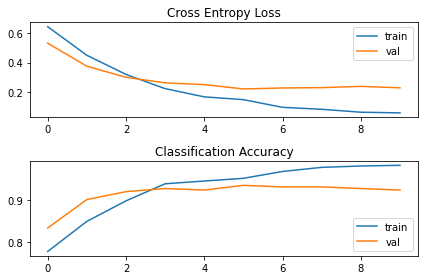

In [13]:
num_epochs = 10
model_name = 'vgg16'

loss_fn = nn.CrossEntropyLoss()
optimizer_vgg = torch.optim.SGD(vgg.parameters(), lr=1e-3)

vgg_train_history, vgg_val_history = train(vgg, model_name, num_epochs, train_dataloader, val_dataloader, loss_fn, optimizer_vgg)

plotTrainingHistory(vgg_train_history, vgg_val_history)